In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label

from skimage.measure import regionprops


np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20


In [2]:
# set the number of object classes
n_classes = 6

In [3]:
X = sorted(glob(r'C:\Users\gestionimg\Documents\Notebooks\data\Full_dataset\images\*.tif'))
Y = sorted(glob(r'C:\Users\gestionimg\Documents\Notebooks\data\Full_dataset\masks\*.tif'))
C = sorted(glob(r'C:\Users\gestionimg\Documents\Notebooks\data\Full_dataset\classification\*.tif'))
assert all(Path(x).name==Path(y).name==Path(c).name for x,y,c in zip(X,Y,C))

In [4]:
# changed intensity_mean to mean_intensity
def label_to_cls_dict(lbl,cls):
    r = 1
    new_dict = {}
    for region in regionprops(lbl,intensity_image=cls):
        id_roi = int(r)
        cls_roi = int(region.mean_intensity)
        new_dict[id_roi] = cls_roi
        r= r + 1
    return(new_dict)

X = list(map(imread,X))
Y = list(map(imread,Y))
C = list(map(imread,C))
#print(len(X))
Cd = list()
for i in range(len(X)) : 
    img, lbl, cls = X[i], Y[i], C[i]
    cls_dict = label_to_cls_dict(lbl,cls)
    Cd.append(cls_dict)


n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

Normalizing image channels independently.


100%|██████████████████████████████████████████████████████████████████████████████| 4981/4981 [00:50<00:00, 98.38it/s]


**First run**

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, C_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val] , [Cd[i] for i in ind_val]
X_trn, Y_trn, C_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train], [Cd[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))
#print(C_val[0])

number of images: 4981
- training:       4234
- validation:     747


In [7]:
help(Config2D)

Help on class Config2D in module stardist.models.model2d:

class Config2D(csbdeep.models.config.BaseConfig)
 |  Config2D(axes='YX', n_rays=32, n_channel_in=1, grid=(1, 1), n_classes=None, backbone='unet', **kwargs)
 |  
 |  Configuration for a :class:`StarDist2D` model.
 |  
 |  Parameters
 |  ----------
 |  axes : str or None
 |      Axes of the input images.
 |  n_rays : int
 |      Number of radial directions for the star-convex polygon.
 |      Recommended to use a power of 2 (default: 32).
 |  n_channel_in : int
 |      Number of channels of given input image (default: 1).
 |  grid : (int,int)
 |      Subsampling factors (must be powers of 2) for each of the axes.
 |      Model will predict on a subsampled grid for increased efficiency and larger field of view.
 |  n_classes : None or int
 |      Number of object classes to use for multi-class predection (use None to disable)
 |  backbone : str
 |      Name of the neural network architecture to be used as backbone.
 |  kwargs : di

In [20]:
# 32 is a good default choice
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    n_classes    = n_classes,   # set the number of object classes
    train_learning_rate = 0.0003,
    unet_n_filter_base = 256,
    train_epochs = 500
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_classes=6, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1, 1, 1, 1, 1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=500, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2, 1), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=256, unet_pool=(2, 2), 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': 6,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 256,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2, 1),
 'train_class_weights': (1, 1, 1, 1, 1, 1, 1),
 'train_epochs': 500,
 'train_steps_per_epoch': 100,
 'train_learning

In [21]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    #limit_gpu_memory(None, allow_growth=True)
    # alternatively, adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)    

In [22]:
model = StarDist2D(conf, name='stardist_multiclass_CoNIC_2022_full_dataset_500_epochs_run_02', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [23]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [24]:
model.train(X_trn,Y_trn, classes=C_trn, validation_data=(X_val,Y_val,C_val), augmenter=augmenter,
            epochs=500) # 200 epochs seem to be enough for synthetic demo dataset

Epoch 1/500
100/100 [==============================] - 56s 563ms/step - loss: 1.7026 - prob_loss: 0.3068 - dist_loss: 3.8952 - prob_class_loss: 0.6168 - prob_kld: 0.2102 - dist_relevant_mae: 3.8949 - dist_relevant_mse: 26.5671 - dist_dist_iou_metric: 0.1470 - val_loss: 1.2888 - val_prob_loss: 0.2165 - val_dist_loss: 3.1316 - val_prob_class_loss: 0.4460 - val_prob_kld: 0.1233 - val_dist_relevant_mae: 3.1312 - val_dist_relevant_mse: 18.5378 - val_dist_dist_iou_metric: 0.2317
Epoch 2/500
100/100 [==============================] - 56s 562ms/step - loss: 1.2606 - prob_loss: 0.2324 - dist_loss: 2.7767 - prob_class_loss: 0.4728 - prob_kld: 0.1399 - dist_relevant_mae: 2.7762 - dist_relevant_mse: 14.3739 - dist_dist_iou_metric: 0.3284 - val_loss: 1.2013 - val_prob_loss: 0.2171 - val_dist_loss: 2.8099 - val_prob_class_loss: 0.4222 - val_prob_kld: 0.1240 - val_dist_relevant_mae: 2.8096 - val_dist_relevant_mse: 16.1083 - val_dist_dist_iou_metric: 0.2699
Epoch 3/500
100/100 [=======================

100/100 [==============================] - 56s 558ms/step - loss: 0.6757 - prob_loss: 0.1546 - dist_loss: 1.3631 - prob_class_loss: 0.2485 - prob_kld: 0.0627 - dist_relevant_mae: 1.3627 - dist_relevant_mse: 5.0721 - dist_dist_iou_metric: 0.6405 - val_loss: 0.7255 - val_prob_loss: 0.1676 - val_dist_loss: 1.4285 - val_prob_class_loss: 0.2722 - val_prob_kld: 0.0744 - val_dist_relevant_mae: 1.4280 - val_dist_relevant_mse: 5.4385 - val_dist_dist_iou_metric: 0.6375
Epoch 18/500
100/100 [==============================] - 56s 565ms/step - loss: 0.6646 - prob_loss: 0.1522 - dist_loss: 1.3456 - prob_class_loss: 0.2432 - prob_kld: 0.0626 - dist_relevant_mae: 1.3452 - dist_relevant_mse: 4.8617 - dist_dist_iou_metric: 0.6431 - val_loss: 0.6729 - val_prob_loss: 0.1538 - val_dist_loss: 1.3565 - val_prob_class_loss: 0.2478 - val_prob_kld: 0.0607 - val_dist_relevant_mae: 1.3557 - val_dist_relevant_mse: 5.0808 - val_dist_dist_iou_metric: 0.6472
Epoch 19/500
100/100 [==============================] - 56s

100/100 [==============================] - 56s 557ms/step - loss: 0.5983 - prob_loss: 0.1479 - dist_loss: 1.1986 - prob_class_loss: 0.2106 - prob_kld: 0.0568 - dist_relevant_mae: 1.1982 - dist_relevant_mse: 4.0599 - dist_dist_iou_metric: 0.6810 - val_loss: 0.6134 - val_prob_loss: 0.1512 - val_dist_loss: 1.2114 - val_prob_class_loss: 0.2199 - val_prob_kld: 0.0581 - val_dist_relevant_mae: 1.2110 - val_dist_relevant_mse: 4.3383 - val_dist_dist_iou_metric: 0.6716
Epoch 35/500
100/100 [==============================] - 56s 560ms/step - loss: 0.5968 - prob_loss: 0.1467 - dist_loss: 1.2297 - prob_class_loss: 0.2041 - prob_kld: 0.0560 - dist_relevant_mae: 1.2293 - dist_relevant_mse: 4.3484 - dist_dist_iou_metric: 0.6761 - val_loss: 0.6074 - val_prob_loss: 0.1499 - val_dist_loss: 1.2325 - val_prob_class_loss: 0.2110 - val_prob_kld: 0.0567 - val_dist_relevant_mae: 1.2321 - val_dist_relevant_mse: 4.4883 - val_dist_dist_iou_metric: 0.6727
Epoch 36/500
100/100 [==============================] - 56s

100/100 [==============================] - 56s 557ms/step - loss: 0.5459 - prob_loss: 0.1340 - dist_loss: 1.1520 - prob_class_loss: 0.1815 - prob_kld: 0.0502 - dist_relevant_mae: 1.1516 - dist_relevant_mse: 3.8152 - dist_dist_iou_metric: 0.6957 - val_loss: 0.5832 - val_prob_loss: 0.1482 - val_dist_loss: 1.1868 - val_prob_class_loss: 0.1976 - val_prob_kld: 0.0551 - val_dist_relevant_mae: 1.1864 - val_dist_relevant_mse: 4.2993 - val_dist_dist_iou_metric: 0.6861
Epoch 52/500
100/100 [==============================] - 56s 564ms/step - loss: 0.5669 - prob_loss: 0.1442 - dist_loss: 1.1634 - prob_class_loss: 0.1901 - prob_kld: 0.0530 - dist_relevant_mae: 1.1630 - dist_relevant_mse: 3.9461 - dist_dist_iou_metric: 0.6945 - val_loss: 0.5701 - val_prob_loss: 0.1465 - val_dist_loss: 1.1623 - val_prob_class_loss: 0.1912 - val_prob_kld: 0.0534 - val_dist_relevant_mae: 1.1620 - val_dist_relevant_mse: 3.9154 - val_dist_dist_iou_metric: 0.6867
Epoch 53/500
100/100 [==============================] - 55s

100/100 [==============================] - 56s 556ms/step - loss: 0.5559 - prob_loss: 0.1468 - dist_loss: 1.1113 - prob_class_loss: 0.1868 - prob_kld: 0.0533 - dist_relevant_mae: 1.1109 - dist_relevant_mse: 3.5913 - dist_dist_iou_metric: 0.7050 - val_loss: 0.5613 - val_prob_loss: 0.1463 - val_dist_loss: 1.1106 - val_prob_class_loss: 0.1929 - val_prob_kld: 0.0532 - val_dist_relevant_mae: 1.1103 - val_dist_relevant_mse: 3.6954 - val_dist_dist_iou_metric: 0.7105
Epoch 69/500
100/100 [==============================] - 55s 555ms/step - loss: 0.5369 - prob_loss: 0.1381 - dist_loss: 1.1044 - prob_class_loss: 0.1779 - prob_kld: 0.0500 - dist_relevant_mae: 1.1040 - dist_relevant_mse: 3.5662 - dist_dist_iou_metric: 0.7059 - val_loss: 0.5537 - val_prob_loss: 0.1461 - val_dist_loss: 1.1089 - val_prob_class_loss: 0.1858 - val_prob_kld: 0.0529 - val_dist_relevant_mae: 1.1086 - val_dist_relevant_mse: 3.6574 - val_dist_dist_iou_metric: 0.7111
Epoch 70/500
100/100 [==============================] - 56s

100/100 [==============================] - 55s 555ms/step - loss: 0.5339 - prob_loss: 0.1427 - dist_loss: 1.0659 - prob_class_loss: 0.1780 - prob_kld: 0.0511 - dist_relevant_mae: 1.0655 - dist_relevant_mse: 3.4021 - dist_dist_iou_metric: 0.7148 - val_loss: 0.5517 - val_prob_loss: 0.1450 - val_dist_loss: 1.0913 - val_prob_class_loss: 0.1885 - val_prob_kld: 0.0518 - val_dist_relevant_mae: 1.0909 - val_dist_relevant_mse: 3.5646 - val_dist_dist_iou_metric: 0.7097
Epoch 86/500
100/100 [==============================] - 55s 554ms/step - loss: 0.5204 - prob_loss: 0.1371 - dist_loss: 1.0449 - prob_class_loss: 0.1743 - prob_kld: 0.0494 - dist_relevant_mae: 1.0445 - dist_relevant_mse: 3.2369 - dist_dist_iou_metric: 0.7181 - val_loss: 0.5398 - val_prob_loss: 0.1440 - val_dist_loss: 1.0784 - val_prob_class_loss: 0.1802 - val_prob_kld: 0.0509 - val_dist_relevant_mae: 1.0781 - val_dist_relevant_mse: 3.5210 - val_dist_dist_iou_metric: 0.7172
Epoch 87/500
100/100 [==============================] - 55s

100/100 [==============================] - 55s 553ms/step - loss: 0.5261 - prob_loss: 0.1419 - dist_loss: 1.0229 - prob_class_loss: 0.1796 - prob_kld: 0.0514 - dist_relevant_mae: 1.0225 - dist_relevant_mse: 3.1915 - dist_dist_iou_metric: 0.7235 - val_loss: 0.5401 - val_prob_loss: 0.1446 - val_dist_loss: 1.0724 - val_prob_class_loss: 0.1810 - val_prob_kld: 0.0515 - val_dist_relevant_mae: 1.0720 - val_dist_relevant_mse: 3.5114 - val_dist_dist_iou_metric: 0.7190
Epoch 103/500
100/100 [==============================] - 55s 553ms/step - loss: 0.5300 - prob_loss: 0.1386 - dist_loss: 1.0680 - prob_class_loss: 0.1778 - prob_kld: 0.0492 - dist_relevant_mae: 1.0676 - dist_relevant_mse: 3.4037 - dist_dist_iou_metric: 0.7183 - val_loss: 0.5474 - val_prob_loss: 0.1455 - val_dist_loss: 1.0700 - val_prob_class_loss: 0.1880 - val_prob_kld: 0.0524 - val_dist_relevant_mae: 1.0696 - val_dist_relevant_mse: 3.5614 - val_dist_dist_iou_metric: 0.7204
Epoch 104/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 555ms/step - loss: 0.5070 - prob_loss: 0.1365 - dist_loss: 1.0105 - prob_class_loss: 0.1684 - prob_kld: 0.0483 - dist_relevant_mae: 1.0101 - dist_relevant_mse: 3.0667 - dist_dist_iou_metric: 0.7260 - val_loss: 0.5505 - val_prob_loss: 0.1442 - val_dist_loss: 1.0687 - val_prob_class_loss: 0.1925 - val_prob_kld: 0.0511 - val_dist_relevant_mae: 1.0684 - val_dist_relevant_mse: 3.5745 - val_dist_dist_iou_metric: 0.7215
Epoch 120/500
100/100 [==============================] - 55s 555ms/step - loss: 0.5315 - prob_loss: 0.1468 - dist_loss: 1.0448 - prob_class_loss: 0.1758 - prob_kld: 0.0515 - dist_relevant_mae: 1.0445 - dist_relevant_mse: 3.3427 - dist_dist_iou_metric: 0.7222 - val_loss: 0.5362 - val_prob_loss: 0.1454 - val_dist_loss: 1.0661 - val_prob_class_loss: 0.1776 - val_prob_kld: 0.0523 - val_dist_relevant_mae: 1.0657 - val_dist_relevant_mse: 3.4559 - val_dist_dist_iou_metric: 0.7279
Epoch 121/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 555ms/step - loss: 0.5066 - prob_loss: 0.1373 - dist_loss: 1.0211 - prob_class_loss: 0.1651 - prob_kld: 0.0484 - dist_relevant_mae: 1.0208 - dist_relevant_mse: 3.1844 - dist_dist_iou_metric: 0.7264 - val_loss: 0.5352 - val_prob_loss: 0.1444 - val_dist_loss: 1.0294 - val_prob_class_loss: 0.1849 - val_prob_kld: 0.0513 - val_dist_relevant_mae: 1.0291 - val_dist_relevant_mse: 3.3571 - val_dist_dist_iou_metric: 0.7294
Epoch 137/500
100/100 [==============================] - 56s 562ms/step - loss: 0.5180 - prob_loss: 0.1416 - dist_loss: 1.0452 - prob_class_loss: 0.1673 - prob_kld: 0.0498 - dist_relevant_mae: 1.0449 - dist_relevant_mse: 3.3770 - dist_dist_iou_metric: 0.7225 - val_loss: 0.5175 - val_prob_loss: 0.1421 - val_dist_loss: 1.0260 - val_prob_class_loss: 0.1701 - val_prob_kld: 0.0490 - val_dist_relevant_mae: 1.0257 - val_dist_relevant_mse: 3.3037 - val_dist_dist_iou_metric: 0.7288
Epoch 138/500
100/100 [==============================] - 5

100/100 [==============================] - 56s 555ms/step - loss: 0.5221 - prob_loss: 0.1442 - dist_loss: 1.0289 - prob_class_loss: 0.1721 - prob_kld: 0.0489 - dist_relevant_mae: 1.0286 - dist_relevant_mse: 3.3436 - dist_dist_iou_metric: 0.7300 - val_loss: 0.5255 - val_prob_loss: 0.1424 - val_dist_loss: 1.0518 - val_prob_class_loss: 0.1728 - val_prob_kld: 0.0493 - val_dist_relevant_mae: 1.0516 - val_dist_relevant_mse: 3.4002 - val_dist_dist_iou_metric: 0.7218
Epoch 154/500
100/100 [==============================] - 55s 553ms/step - loss: 0.5031 - prob_loss: 0.1377 - dist_loss: 0.9990 - prob_class_loss: 0.1656 - prob_kld: 0.0472 - dist_relevant_mae: 0.9987 - dist_relevant_mse: 3.0756 - dist_dist_iou_metric: 0.7312 - val_loss: 0.5184 - val_prob_loss: 0.1422 - val_dist_loss: 1.0356 - val_prob_class_loss: 0.1691 - val_prob_kld: 0.0491 - val_dist_relevant_mae: 1.0353 - val_dist_relevant_mse: 3.3469 - val_dist_dist_iou_metric: 0.7314
Epoch 155/500
100/100 [==============================] - 5

100/100 [==============================] - 56s 561ms/step - loss: 0.5085 - prob_loss: 0.1419 - dist_loss: 1.0188 - prob_class_loss: 0.1628 - prob_kld: 0.0488 - dist_relevant_mae: 1.0185 - dist_relevant_mse: 3.2338 - dist_dist_iou_metric: 0.7312 - val_loss: 0.5064 - val_prob_loss: 0.1404 - val_dist_loss: 1.0111 - val_prob_class_loss: 0.1638 - val_prob_kld: 0.0473 - val_dist_relevant_mae: 1.0108 - val_dist_relevant_mse: 3.2896 - val_dist_dist_iou_metric: 0.7302
Epoch 171/500
100/100 [==============================] - 55s 553ms/step - loss: 0.5088 - prob_loss: 0.1414 - dist_loss: 1.0123 - prob_class_loss: 0.1649 - prob_kld: 0.0478 - dist_relevant_mae: 1.0121 - dist_relevant_mse: 3.2265 - dist_dist_iou_metric: 0.7323 - val_loss: 0.5118 - val_prob_loss: 0.1413 - val_dist_loss: 1.0251 - val_prob_class_loss: 0.1654 - val_prob_kld: 0.0482 - val_dist_relevant_mae: 1.0248 - val_dist_relevant_mse: 3.3357 - val_dist_dist_iou_metric: 0.7369
Epoch 172/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 553ms/step - loss: 0.4972 - prob_loss: 0.1385 - dist_loss: 0.9733 - prob_class_loss: 0.1641 - prob_kld: 0.0473 - dist_relevant_mae: 0.9730 - dist_relevant_mse: 2.9612 - dist_dist_iou_metric: 0.7351 - val_loss: 0.5098 - val_prob_loss: 0.1414 - val_dist_loss: 1.0175 - val_prob_class_loss: 0.1649 - val_prob_kld: 0.0483 - val_dist_relevant_mae: 1.0173 - val_dist_relevant_mse: 3.2673 - val_dist_dist_iou_metric: 0.7320
Epoch 188/500
100/100 [==============================] - 55s 554ms/step - loss: 0.5091 - prob_loss: 0.1411 - dist_loss: 1.0235 - prob_class_loss: 0.1633 - prob_kld: 0.0480 - dist_relevant_mae: 1.0232 - dist_relevant_mse: 3.2478 - dist_dist_iou_metric: 0.7323 - val_loss: 0.5084 - val_prob_loss: 0.1411 - val_dist_loss: 1.0073 - val_prob_class_loss: 0.1658 - val_prob_kld: 0.0480 - val_dist_relevant_mae: 1.0071 - val_dist_relevant_mse: 3.2555 - val_dist_dist_iou_metric: 0.7345
Epoch 189/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 553ms/step - loss: 0.5009 - prob_loss: 0.1400 - dist_loss: 1.0113 - prob_class_loss: 0.1587 - prob_kld: 0.0467 - dist_relevant_mae: 1.0110 - dist_relevant_mse: 3.1835 - dist_dist_iou_metric: 0.7370 - val_loss: 0.5111 - val_prob_loss: 0.1410 - val_dist_loss: 1.0203 - val_prob_class_loss: 0.1660 - val_prob_kld: 0.0479 - val_dist_relevant_mae: 1.0200 - val_dist_relevant_mse: 3.2930 - val_dist_dist_iou_metric: 0.7349
Epoch 205/500
100/100 [==============================] - 55s 554ms/step - loss: 0.4852 - prob_loss: 0.1349 - dist_loss: 0.9800 - prob_class_loss: 0.1543 - prob_kld: 0.0452 - dist_relevant_mae: 0.9798 - dist_relevant_mse: 2.9959 - dist_dist_iou_metric: 0.7380 - val_loss: 0.5026 - val_prob_loss: 0.1404 - val_dist_loss: 0.9937 - val_prob_class_loss: 0.1635 - val_prob_kld: 0.0473 - val_dist_relevant_mae: 0.9934 - val_dist_relevant_mse: 3.2089 - val_dist_dist_iou_metric: 0.7379
Epoch 206/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 554ms/step - loss: 0.4987 - prob_loss: 0.1432 - dist_loss: 0.9739 - prob_class_loss: 0.1607 - prob_kld: 0.0475 - dist_relevant_mae: 0.9737 - dist_relevant_mse: 2.9586 - dist_dist_iou_metric: 0.7411 - val_loss: 0.5054 - val_prob_loss: 0.1408 - val_dist_loss: 1.0046 - val_prob_class_loss: 0.1637 - val_prob_kld: 0.0477 - val_dist_relevant_mae: 1.0043 - val_dist_relevant_mse: 3.2306 - val_dist_dist_iou_metric: 0.7362
Epoch 222/500
100/100 [==============================] - 55s 553ms/step - loss: 0.4676 - prob_loss: 0.1254 - dist_loss: 0.9943 - prob_class_loss: 0.1434 - prob_kld: 0.0426 - dist_relevant_mae: 0.9941 - dist_relevant_mse: 3.1085 - dist_dist_iou_metric: 0.7370 - val_loss: 0.5022 - val_prob_loss: 0.1403 - val_dist_loss: 1.0050 - val_prob_class_loss: 0.1608 - val_prob_kld: 0.0472 - val_dist_relevant_mae: 1.0048 - val_dist_relevant_mse: 3.2643 - val_dist_dist_iou_metric: 0.7404
Epoch 223/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 553ms/step - loss: 0.4941 - prob_loss: 0.1377 - dist_loss: 1.0025 - prob_class_loss: 0.1559 - prob_kld: 0.0465 - dist_relevant_mae: 1.0022 - dist_relevant_mse: 3.1714 - dist_dist_iou_metric: 0.7366 - val_loss: 0.5025 - val_prob_loss: 0.1412 - val_dist_loss: 0.9920 - val_prob_class_loss: 0.1629 - val_prob_kld: 0.0481 - val_dist_relevant_mae: 0.9917 - val_dist_relevant_mse: 3.2266 - val_dist_dist_iou_metric: 0.7397
Epoch 239/500
100/100 [==============================] - 55s 554ms/step - loss: 0.4851 - prob_loss: 0.1350 - dist_loss: 0.9861 - prob_class_loss: 0.1528 - prob_kld: 0.0447 - dist_relevant_mae: 0.9858 - dist_relevant_mse: 3.0562 - dist_dist_iou_metric: 0.7387 - val_loss: 0.5008 - val_prob_loss: 0.1402 - val_dist_loss: 0.9954 - val_prob_class_loss: 0.1616 - val_prob_kld: 0.0470 - val_dist_relevant_mae: 0.9952 - val_dist_relevant_mse: 3.2843 - val_dist_dist_iou_metric: 0.7353
Epoch 240/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 552ms/step - loss: 0.4862 - prob_loss: 0.1374 - dist_loss: 0.9775 - prob_class_loss: 0.1533 - prob_kld: 0.0456 - dist_relevant_mae: 0.9773 - dist_relevant_mse: 3.0551 - dist_dist_iou_metric: 0.7408 - val_loss: 0.4972 - val_prob_loss: 0.1397 - val_dist_loss: 0.9782 - val_prob_class_loss: 0.1619 - val_prob_kld: 0.0466 - val_dist_relevant_mae: 0.9779 - val_dist_relevant_mse: 3.1840 - val_dist_dist_iou_metric: 0.7433
Epoch 256/500
100/100 [==============================] - 55s 553ms/step - loss: 0.4739 - prob_loss: 0.1341 - dist_loss: 0.9451 - prob_class_loss: 0.1508 - prob_kld: 0.0440 - dist_relevant_mae: 0.9448 - dist_relevant_mse: 2.9505 - dist_dist_iou_metric: 0.7462 - val_loss: 0.4977 - val_prob_loss: 0.1403 - val_dist_loss: 0.9873 - val_prob_class_loss: 0.1600 - val_prob_kld: 0.0472 - val_dist_relevant_mae: 0.9870 - val_dist_relevant_mse: 3.1945 - val_dist_dist_iou_metric: 0.7405
Epoch 257/500
100/100 [==============================] - 5

100/100 [==============================] - 56s 557ms/step - loss: 0.4608 - prob_loss: 0.1295 - dist_loss: 0.9401 - prob_class_loss: 0.1433 - prob_kld: 0.0432 - dist_relevant_mae: 0.9399 - dist_relevant_mse: 2.7822 - dist_dist_iou_metric: 0.7452 - val_loss: 0.4962 - val_prob_loss: 0.1402 - val_dist_loss: 0.9842 - val_prob_class_loss: 0.1592 - val_prob_kld: 0.0471 - val_dist_relevant_mae: 0.9840 - val_dist_relevant_mse: 3.1774 - val_dist_dist_iou_metric: 0.7433
Epoch 273/500
100/100 [==============================] - 55s 552ms/step - loss: 0.5001 - prob_loss: 0.1422 - dist_loss: 0.9810 - prob_class_loss: 0.1617 - prob_kld: 0.0469 - dist_relevant_mae: 0.9808 - dist_relevant_mse: 3.0384 - dist_dist_iou_metric: 0.7421 - val_loss: 0.5040 - val_prob_loss: 0.1410 - val_dist_loss: 0.9998 - val_prob_class_loss: 0.1630 - val_prob_kld: 0.0479 - val_dist_relevant_mae: 0.9996 - val_dist_relevant_mse: 3.2274 - val_dist_dist_iou_metric: 0.7351
Epoch 274/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 554ms/step - loss: 0.4704 - prob_loss: 0.1348 - dist_loss: 0.9387 - prob_class_loss: 0.1479 - prob_kld: 0.0444 - dist_relevant_mae: 0.9385 - dist_relevant_mse: 2.7999 - dist_dist_iou_metric: 0.7473 - val_loss: 0.4969 - val_prob_loss: 0.1401 - val_dist_loss: 0.9871 - val_prob_class_loss: 0.1594 - val_prob_kld: 0.0470 - val_dist_relevant_mae: 0.9869 - val_dist_relevant_mse: 3.2120 - val_dist_dist_iou_metric: 0.7449
Epoch 290/500
100/100 [==============================] - 55s 552ms/step - loss: 0.4818 - prob_loss: 0.1349 - dist_loss: 0.9648 - prob_class_loss: 0.1539 - prob_kld: 0.0448 - dist_relevant_mae: 0.9646 - dist_relevant_mse: 3.0109 - dist_dist_iou_metric: 0.7448 - val_loss: 0.5232 - val_prob_loss: 0.1412 - val_dist_loss: 1.0088 - val_prob_class_loss: 0.1802 - val_prob_kld: 0.0480 - val_dist_relevant_mae: 1.0086 - val_dist_relevant_mse: 3.3115 - val_dist_dist_iou_metric: 0.7372
Epoch 291/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 554ms/step - loss: 0.4742 - prob_loss: 0.1342 - dist_loss: 0.9734 - prob_class_loss: 0.1453 - prob_kld: 0.0441 - dist_relevant_mae: 0.9732 - dist_relevant_mse: 3.0321 - dist_dist_iou_metric: 0.7430 - val_loss: 0.4966 - val_prob_loss: 0.1397 - val_dist_loss: 0.9892 - val_prob_class_loss: 0.1591 - val_prob_kld: 0.0466 - val_dist_relevant_mae: 0.9890 - val_dist_relevant_mse: 3.2134 - val_dist_dist_iou_metric: 0.7442
Epoch 307/500
100/100 [==============================] - 56s 562ms/step - loss: 0.4744 - prob_loss: 0.1341 - dist_loss: 0.9735 - prob_class_loss: 0.1456 - prob_kld: 0.0441 - dist_relevant_mae: 0.9732 - dist_relevant_mse: 3.0074 - dist_dist_iou_metric: 0.7418 - val_loss: 0.4883 - val_prob_loss: 0.1394 - val_dist_loss: 0.9748 - val_prob_class_loss: 0.1540 - val_prob_kld: 0.0463 - val_dist_relevant_mae: 0.9746 - val_dist_relevant_mse: 3.1561 - val_dist_dist_iou_metric: 0.7451
Epoch 308/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 553ms/step - loss: 0.4679 - prob_loss: 0.1318 - dist_loss: 0.9567 - prob_class_loss: 0.1448 - prob_kld: 0.0439 - dist_relevant_mae: 0.9565 - dist_relevant_mse: 2.9474 - dist_dist_iou_metric: 0.7451 - val_loss: 0.4934 - val_prob_loss: 0.1403 - val_dist_loss: 0.9791 - val_prob_class_loss: 0.1573 - val_prob_kld: 0.0472 - val_dist_relevant_mae: 0.9788 - val_dist_relevant_mse: 3.1696 - val_dist_dist_iou_metric: 0.7408
Epoch 324/500
100/100 [==============================] - 55s 552ms/step - loss: 0.4612 - prob_loss: 0.1310 - dist_loss: 0.9446 - prob_class_loss: 0.1413 - prob_kld: 0.0432 - dist_relevant_mae: 0.9444 - dist_relevant_mse: 2.8801 - dist_dist_iou_metric: 0.7452 - val_loss: 0.4959 - val_prob_loss: 0.1404 - val_dist_loss: 0.9900 - val_prob_class_loss: 0.1575 - val_prob_kld: 0.0473 - val_dist_relevant_mae: 0.9898 - val_dist_relevant_mse: 3.2292 - val_dist_dist_iou_metric: 0.7368
Epoch 325/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 553ms/step - loss: 0.4721 - prob_loss: 0.1356 - dist_loss: 0.9772 - prob_class_loss: 0.1410 - prob_kld: 0.0438 - dist_relevant_mae: 0.9770 - dist_relevant_mse: 3.0636 - dist_dist_iou_metric: 0.7436 - val_loss: 0.4901 - val_prob_loss: 0.1396 - val_dist_loss: 0.9779 - val_prob_class_loss: 0.1549 - val_prob_kld: 0.0464 - val_dist_relevant_mae: 0.9777 - val_dist_relevant_mse: 3.1842 - val_dist_dist_iou_metric: 0.7439
Epoch 341/500
100/100 [==============================] - 55s 555ms/step - loss: 0.4624 - prob_loss: 0.1318 - dist_loss: 0.9544 - prob_class_loss: 0.1397 - prob_kld: 0.0428 - dist_relevant_mae: 0.9542 - dist_relevant_mse: 2.9381 - dist_dist_iou_metric: 0.7488 - val_loss: 0.4886 - val_prob_loss: 0.1394 - val_dist_loss: 0.9719 - val_prob_class_loss: 0.1549 - val_prob_kld: 0.0463 - val_dist_relevant_mae: 0.9716 - val_dist_relevant_mse: 3.1236 - val_dist_dist_iou_metric: 0.7468
Epoch 342/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 554ms/step - loss: 0.4600 - prob_loss: 0.1318 - dist_loss: 0.9471 - prob_class_loss: 0.1388 - prob_kld: 0.0427 - dist_relevant_mae: 0.9469 - dist_relevant_mse: 2.9050 - dist_dist_iou_metric: 0.7481 - val_loss: 0.4925 - val_prob_loss: 0.1398 - val_dist_loss: 0.9868 - val_prob_class_loss: 0.1553 - val_prob_kld: 0.0467 - val_dist_relevant_mae: 0.9866 - val_dist_relevant_mse: 3.2230 - val_dist_dist_iou_metric: 0.7381
Epoch 358/500
100/100 [==============================] - 56s 557ms/step - loss: 0.4699 - prob_loss: 0.1351 - dist_loss: 0.9588 - prob_class_loss: 0.1431 - prob_kld: 0.0443 - dist_relevant_mae: 0.9586 - dist_relevant_mse: 2.9539 - dist_dist_iou_metric: 0.7459 - val_loss: 0.4868 - val_prob_loss: 0.1392 - val_dist_loss: 0.9721 - val_prob_class_loss: 0.1532 - val_prob_kld: 0.0460 - val_dist_relevant_mae: 0.9719 - val_dist_relevant_mse: 3.1437 - val_dist_dist_iou_metric: 0.7464
Epoch 359/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 554ms/step - loss: 0.4747 - prob_loss: 0.1377 - dist_loss: 0.9680 - prob_class_loss: 0.1434 - prob_kld: 0.0445 - dist_relevant_mae: 0.9677 - dist_relevant_mse: 3.0893 - dist_dist_iou_metric: 0.7460 - val_loss: 0.4887 - val_prob_loss: 0.1394 - val_dist_loss: 0.9803 - val_prob_class_loss: 0.1532 - val_prob_kld: 0.0463 - val_dist_relevant_mae: 0.9801 - val_dist_relevant_mse: 3.2196 - val_dist_dist_iou_metric: 0.7398
Epoch 375/500
100/100 [==============================] - 55s 552ms/step - loss: 0.4541 - prob_loss: 0.1285 - dist_loss: 0.9461 - prob_class_loss: 0.1364 - prob_kld: 0.0423 - dist_relevant_mae: 0.9459 - dist_relevant_mse: 2.9097 - dist_dist_iou_metric: 0.7471 - val_loss: 0.4975 - val_prob_loss: 0.1404 - val_dist_loss: 0.9869 - val_prob_class_loss: 0.1598 - val_prob_kld: 0.0473 - val_dist_relevant_mae: 0.9867 - val_dist_relevant_mse: 3.2240 - val_dist_dist_iou_metric: 0.7411
Epoch 376/500
100/100 [==============================] - 5

100/100 [==============================] - 56s 557ms/step - loss: 0.4680 - prob_loss: 0.1353 - dist_loss: 0.9325 - prob_class_loss: 0.1462 - prob_kld: 0.0447 - dist_relevant_mae: 0.9323 - dist_relevant_mse: 2.7864 - dist_dist_iou_metric: 0.7485 - val_loss: 0.4869 - val_prob_loss: 0.1392 - val_dist_loss: 0.9731 - val_prob_class_loss: 0.1531 - val_prob_kld: 0.0460 - val_dist_relevant_mae: 0.9728 - val_dist_relevant_mse: 3.1473 - val_dist_dist_iou_metric: 0.7429
Epoch 392/500
100/100 [==============================] - 55s 553ms/step - loss: 0.4506 - prob_loss: 0.1270 - dist_loss: 0.9506 - prob_class_loss: 0.1335 - prob_kld: 0.0411 - dist_relevant_mae: 0.9503 - dist_relevant_mse: 2.9230 - dist_dist_iou_metric: 0.7494 - val_loss: 0.4867 - val_prob_loss: 0.1393 - val_dist_loss: 0.9728 - val_prob_class_loss: 0.1528 - val_prob_kld: 0.0462 - val_dist_relevant_mae: 0.9726 - val_dist_relevant_mse: 3.1517 - val_dist_dist_iou_metric: 0.7424
Epoch 393/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 553ms/step - loss: 0.4540 - prob_loss: 0.1320 - dist_loss: 0.9284 - prob_class_loss: 0.1363 - prob_kld: 0.0418 - dist_relevant_mae: 0.9281 - dist_relevant_mse: 2.7399 - dist_dist_iou_metric: 0.7524 - val_loss: 0.4886 - val_prob_loss: 0.1403 - val_dist_loss: 0.9710 - val_prob_class_loss: 0.1542 - val_prob_kld: 0.0471 - val_dist_relevant_mae: 0.9707 - val_dist_relevant_mse: 3.1430 - val_dist_dist_iou_metric: 0.7486
Epoch 409/500
100/100 [==============================] - 55s 553ms/step - loss: 0.4585 - prob_loss: 0.1328 - dist_loss: 0.9369 - prob_class_loss: 0.1383 - prob_kld: 0.0435 - dist_relevant_mae: 0.9367 - dist_relevant_mse: 2.8384 - dist_dist_iou_metric: 0.7496 - val_loss: 0.4885 - val_prob_loss: 0.1398 - val_dist_loss: 0.9745 - val_prob_class_loss: 0.1538 - val_prob_kld: 0.0467 - val_dist_relevant_mae: 0.9743 - val_dist_relevant_mse: 3.1799 - val_dist_dist_iou_metric: 0.7456
Epoch 410/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 552ms/step - loss: 0.4584 - prob_loss: 0.1319 - dist_loss: 0.9472 - prob_class_loss: 0.1371 - prob_kld: 0.0426 - dist_relevant_mae: 0.9470 - dist_relevant_mse: 2.8938 - dist_dist_iou_metric: 0.7489 - val_loss: 0.4857 - val_prob_loss: 0.1390 - val_dist_loss: 0.9667 - val_prob_class_loss: 0.1534 - val_prob_kld: 0.0459 - val_dist_relevant_mae: 0.9664 - val_dist_relevant_mse: 3.1477 - val_dist_dist_iou_metric: 0.7436
Epoch 426/500
100/100 [==============================] - ETA: 0s - loss: 0.4488 - prob_loss: 0.1300 - dist_loss: 0.9256 - prob_class_loss: 0.1337 - prob_kld: 0.0413 - dist_relevant_mae: 0.9254 - dist_relevant_mse: 2.7339 - dist_dist_iou_metric: 0.7538
Epoch 00426: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
100/100 [==============================] - 55s 552ms/step - loss: 0.4488 - prob_loss: 0.1300 - dist_loss: 0.9256 - prob_class_loss: 0.1337 - prob_kld: 0.0413 - dist_relevant_mae: 0.9254 - dist_relevant_ms

100/100 [==============================] - 55s 554ms/step - loss: 0.4418 - prob_loss: 0.1286 - dist_loss: 0.9303 - prob_class_loss: 0.1271 - prob_kld: 0.0395 - dist_relevant_mae: 0.9301 - dist_relevant_mse: 2.7768 - dist_dist_iou_metric: 0.7573 - val_loss: 0.4817 - val_prob_loss: 0.1390 - val_dist_loss: 0.9664 - val_prob_class_loss: 0.1493 - val_prob_kld: 0.0459 - val_dist_relevant_mae: 0.9661 - val_dist_relevant_mse: 3.1143 - val_dist_dist_iou_metric: 0.7480
Epoch 442/500
100/100 [==============================] - 55s 553ms/step - loss: 0.4356 - prob_loss: 0.1286 - dist_loss: 0.8972 - prob_class_loss: 0.1276 - prob_kld: 0.0404 - dist_relevant_mae: 0.8970 - dist_relevant_mse: 2.5627 - dist_dist_iou_metric: 0.7561 - val_loss: 0.4798 - val_prob_loss: 0.1384 - val_dist_loss: 0.9621 - val_prob_class_loss: 0.1489 - val_prob_kld: 0.0453 - val_dist_relevant_mae: 0.9619 - val_dist_relevant_mse: 3.1145 - val_dist_dist_iou_metric: 0.7492
Epoch 443/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 553ms/step - loss: 0.4217 - prob_loss: 0.1241 - dist_loss: 0.8767 - prob_class_loss: 0.1223 - prob_kld: 0.0384 - dist_relevant_mae: 0.8765 - dist_relevant_mse: 2.4869 - dist_dist_iou_metric: 0.7620 - val_loss: 0.4801 - val_prob_loss: 0.1390 - val_dist_loss: 0.9542 - val_prob_class_loss: 0.1503 - val_prob_kld: 0.0459 - val_dist_relevant_mae: 0.9540 - val_dist_relevant_mse: 3.0805 - val_dist_dist_iou_metric: 0.7486
Epoch 459/500
100/100 [==============================] - 56s 556ms/step - loss: 0.4384 - prob_loss: 0.1290 - dist_loss: 0.9075 - prob_class_loss: 0.1279 - prob_kld: 0.0403 - dist_relevant_mae: 0.9073 - dist_relevant_mse: 2.6716 - dist_dist_iou_metric: 0.7567 - val_loss: 0.4773 - val_prob_loss: 0.1383 - val_dist_loss: 0.9533 - val_prob_class_loss: 0.1483 - val_prob_kld: 0.0452 - val_dist_relevant_mae: 0.9531 - val_dist_relevant_mse: 3.0613 - val_dist_dist_iou_metric: 0.7487
Epoch 460/500
100/100 [==============================] - 5

100/100 [==============================] - 56s 563ms/step - loss: 0.4437 - prob_loss: 0.1341 - dist_loss: 0.8918 - prob_class_loss: 0.1313 - prob_kld: 0.0415 - dist_relevant_mae: 0.8916 - dist_relevant_mse: 2.5756 - dist_dist_iou_metric: 0.7602 - val_loss: 0.4777 - val_prob_loss: 0.1384 - val_dist_loss: 0.9540 - val_prob_class_loss: 0.1485 - val_prob_kld: 0.0453 - val_dist_relevant_mae: 0.9538 - val_dist_relevant_mse: 3.0848 - val_dist_dist_iou_metric: 0.7495
Epoch 475/500
100/100 [==============================] - 56s 558ms/step - loss: 0.4303 - prob_loss: 0.1284 - dist_loss: 0.8819 - prob_class_loss: 0.1255 - prob_kld: 0.0395 - dist_relevant_mae: 0.8817 - dist_relevant_mse: 2.5300 - dist_dist_iou_metric: 0.7610 - val_loss: 0.4766 - val_prob_loss: 0.1388 - val_dist_loss: 0.9474 - val_prob_class_loss: 0.1483 - val_prob_kld: 0.0457 - val_dist_relevant_mae: 0.9472 - val_dist_relevant_mse: 3.0656 - val_dist_dist_iou_metric: 0.7516
Epoch 476/500
100/100 [==============================] - 5

100/100 [==============================] - 55s 553ms/step - loss: 0.4438 - prob_loss: 0.1375 - dist_loss: 0.8710 - prob_class_loss: 0.1321 - prob_kld: 0.0418 - dist_relevant_mae: 0.8708 - dist_relevant_mse: 2.4738 - dist_dist_iou_metric: 0.7623 - val_loss: 0.4773 - val_prob_loss: 0.1386 - val_dist_loss: 0.9485 - val_prob_class_loss: 0.1490 - val_prob_kld: 0.0455 - val_dist_relevant_mae: 0.9483 - val_dist_relevant_mse: 3.0756 - val_dist_dist_iou_metric: 0.7506
Epoch 492/500
100/100 [==============================] - 55s 552ms/step - loss: 0.4377 - prob_loss: 0.1308 - dist_loss: 0.9066 - prob_class_loss: 0.1256 - prob_kld: 0.0398 - dist_relevant_mae: 0.9064 - dist_relevant_mse: 2.7232 - dist_dist_iou_metric: 0.7593 - val_loss: 0.4802 - val_prob_loss: 0.1389 - val_dist_loss: 0.9555 - val_prob_class_loss: 0.1502 - val_prob_kld: 0.0458 - val_dist_relevant_mae: 0.9553 - val_dist_relevant_mse: 3.0775 - val_dist_dist_iou_metric: 0.7498
Epoch 493/500
100/100 [==============================] - 5

In [25]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████████████████████████████████         | 16/20 [03:25<00:51, 12.87s/it, 0.501 -> 0.686]


Using optimized values: prob_thresh=0.49977, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.49976980686187744, 'nms': 0.3}

In [26]:
i = 100
label, res = model.predict_instances(X_val[i], n_tiles=model._guess_n_tiles(X_val[i]))

In [27]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 

def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict

print(class_from_res(res))

{1: 3, 2: 3, 3: 4, 4: 3, 5: 4, 6: 3, 7: 4, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 2, 17: 2, 18: 4, 19: 6, 20: 3, 21: 3, 22: 2, 23: 2, 24: 6, 25: 6, 26: 4, 27: 4, 28: 6, 29: 2, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2, 35: 4, 36: 2, 37: 2, 38: 2, 39: 2, 40: 6, 41: 4, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 2, 48: 6, 49: 2, 50: 2, 51: 2, 52: 6, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 2, 61: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 6, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 2, 80: 3, 81: 2, 82: 2, 83: 2, 84: 2, 85: 6, 86: 2, 87: 6, 88: 2, 89: 2, 90: 2, 91: 2, 92: 6, 93: 2, 94: 2, 95: 2, 96: 0, 97: 6, 98: 2, 99: 2, 100: 2, 101: 0, 102: 2}


In [28]:
Y_val_pred, res_val_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_val[:])]))

100%|████████████████████████████████████████████████████████████████████████████████| 747/747 [01:42<00:00,  7.28it/s]


In [29]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  3.00s/it]


In [30]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=9441, tp=69955, fn=16602, precision=0.8810897274421885, recall=0.8081957553981769, accuracy=0.7287130981895457, f1=0.8430700258506927, n_true=86557, n_pred=79396, mean_true_score=0.6516442909279505, mean_matched_score=0.8062951167157546, panoptic_quality=0.6797632448928386, by_image=False)

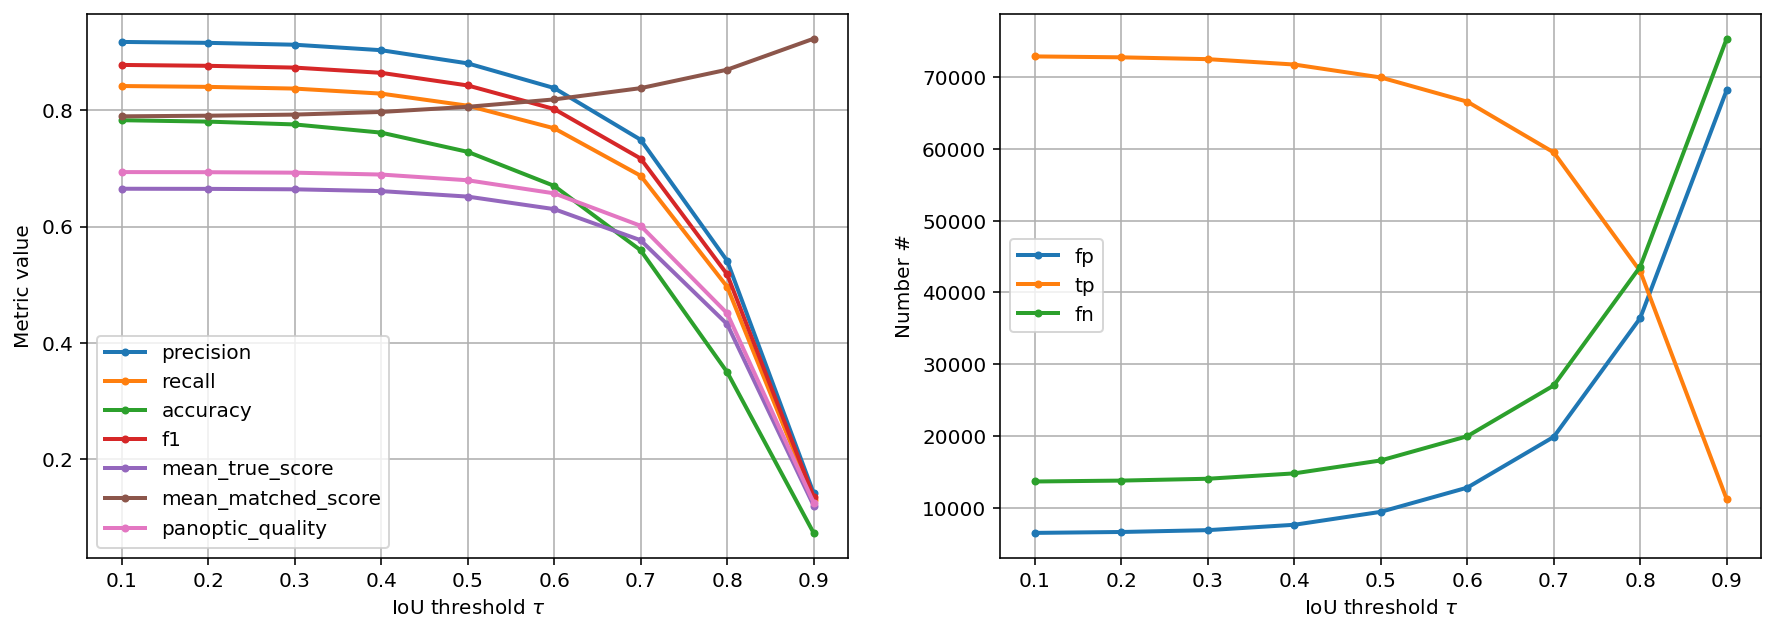

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();